In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow import keras

import cirq
import sympy
import numpy as np
import collections
import qsimcirq

# visualization tools
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import datetime

In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_quantum as tfq

2022-05-27 21:31:30.391574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 21:31:30.399570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 21:31:30.401084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 21:31:30.573008: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Trainable Quanvolutional Neural Network

## Load dataset

In [4]:
n_train = 5000    # Size of the train dataset
n_test  = 2000    # Size of the test dataset
ansatz = 1

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
if ansatz == 1:
    train_images = train_images / 255
    test_images = test_images / 255
elif ansatz==2:
    train_images = train_images / 128 - 1
    test_images = test_images / 128 - 1
elif ansatz==3:
    print('non devo fare nulla miao\nChing Chong è un boss')

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])

# reduce image resolution
train_images = tf.image.resize(train_images[:], (14,14)).numpy()
test_images = tf.image.resize(test_images[:], (14,14)).numpy()

## Define QConv layer

### Ansatz 1) found on the internet

In [5]:
debug=True
options = qsimcirq.QSimOptions(use_gpu=True, max_fused_gate_size=4, gpu_mode=1)
s = qsimcirq.QSimSimulator(options)
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, strides=(1, 1), activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = (filter_size, filter_size) if type(filter_size)==int else filter_size
        self.pixels = self.filter_size[0]*self.filter_size[1]
        self.depth = depth
        self.strides = strides
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
    
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        cirq_qubits = cirq.GridQubit.rect(self.filter_size[0]*self.depth, self.filter_size[1])      # a circuit for each depth
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(self.pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i%self.pixels])(qubit))                                 # input params repeats for each depth
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(self.pixels).astype(np.int32))]                                    # add for in depth
        
        if np.log2(self.pixels) % 1 == 0:
            for i in range(self.depth):
                skip = i*self.pixels
                for step in step_size:
                    for target in range(0, self.pixels, 2*step):
                        QCNN_circuit.append(self._QConv(step, target+skip, cirq_qubits))                        # split the circuits
        else:
            for i in range(self.depth):
                skip = i*self.pixels
                for target in range(self.pixels-1):
                    QCNN_circuit.append(self._QConv(1, target+skip, cirq_qubits))                               # split the circuits
                QCNN_circuit.append(self._QConv(1-self.pixels, self.pixels-1+skip, cirq_qubits))
                
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        
        self.params = input_params + self.learning_params
        self.op = [cirq.Z(cirq_qubits[(i+1)]) for i in range(0, len(cirq_qubits), self.pixels)]                      # measure
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = (self.width - self.filter_size[0]) // self.strides[0] + 1
        self.num_y = (self.height - self.filter_size[1]) // self.strides[1] + 1
        if(((self.width - self.filter_size[0]) % self.strides[0]) or 
           ((self.height - self.filter_size[1]) % self.strides[1])):
            if(((self.width - self.filter_size[0]) % self.strides[0]) and 
               ((self.height - self.filter_size[1]) % self.strides[1])):
                print("WARNING: cutting image borders, consider changing filter size or stride on both dimensions")    
            elif((self.height - self.filter_size[1]) % self.strides[1]):
                print("WARNING: cutting image borders, consider changing filter size or stride on dimension 1")
            else:
                print("WARNING: cutting image borders, consider changing filter size or stride along dimension 0")
                
        self.kernel = self.add_weight(name="kenel",                                                                     # careful with self.learning_params
                                      shape=[self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        print('circuit_tensor:', self.circuit_tensor.shape)
        

    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(0, self.width-self.filter_size[0]+1, self.strides[0]):
            for j in range(0, self.height-self.filter_size[1]+1, self.strides[1]):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size[0], self.filter_size[1], -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size[0], self.filter_size[1], self.channel])
                if debug:
                    print('i, j:', i, j)
                    print('slice_part:', slice_part.shape)
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1) 
        if debug:
            print('stack_set:', stack_set.shape) 
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size[0]*self.filter_size[1]])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        if debug:
            print(stack_set.shape, stack_set)
        # total input circuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        #tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        
        controller = tf.tile(self.kernel, [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
        outputs=self.single_depth_QCNN(stack_set, controller, circuit_inputs)
        # shape: [N, num_x, num_y, self.depth] 
            
        output_tensor = outputs #tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
    
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation(backend=s)(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel, self.depth])
        return tf.math.reduce_sum(QCNN_output, 3)

    @property
    def svg(self):
        circtoplot = self.circuit
        circtoplot.append(self.op)
        return SVGCircuit(circtoplot)

### PORCODIOOO

In [9]:
debug=False
options = qsimcirq.QSimOptions(use_gpu=True, max_fused_gate_size=2, gpu_mode=1, denormals_are_zeros=True)
s = qsimcirq.QSimSimulator(options)
class QConv(tf.keras.layers.Layer.Conv2D):
    def __init__(self, filter_size, depth, strides=(1, 1), activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = (filter_size, filter_size) if type(filter_size)==int else filter_size
        self.pixels = self.filter_size[0]*self.filter_size[1]
        self.depth = depth
        self.strides = strides
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
    
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        cirq_qubits = cirq.GridQubit.rect(self.filter_size[0]*self.depth, self.filter_size[1])      # a circuit for each depth
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(self.pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i%self.pixels])(qubit))                                 # input params repeats for each depth
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(self.pixels).astype(np.int32))]                                    # add for in depth
        
        if np.log2(self.pixels) % 1 == 0:
            for i in range(self.depth):
                skip = i*self.pixels
                for step in step_size:
                    for target in range(0, self.pixels, 2*step):
                        QCNN_circuit.append(self._QConv(step, target+skip, cirq_qubits))                        # split the circuits
        else:
            for i in range(self.depth):
                skip = i*self.pixels
                for target in range(self.pixels-1):
                    QCNN_circuit.append(self._QConv(1, target+skip, cirq_qubits))                               # split the circuits
                QCNN_circuit.append(self._QConv(1-self.pixels, self.pixels-1+skip, cirq_qubits))
                
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        
        self.params = input_params + self.learning_params
        self.op = [cirq.Z(cirq_qubits[(i+1)]) for i in range(0, len(cirq_qubits), self.pixels)]                      # measure
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = (self.width - self.filter_size[0]) // self.strides[0] + 1
        self.num_y = (self.height - self.filter_size[1]) // self.strides[1] + 1
        if(((self.width - self.filter_size[0]) % self.strides[0]) or 
           ((self.height - self.filter_size[1]) % self.strides[1])):
            if(((self.width - self.filter_size[0]) % self.strides[0]) and 
               ((self.height - self.filter_size[1]) % self.strides[1])):
                print("WARNING: cutting image borders, consider changing filter size or stride on both dimensions")    
            elif((self.height - self.filter_size[1]) % self.strides[1]):
                print("WARNING: cutting image borders, consider changing filter size or stride on dimension 1")
            else:
                print("WARNING: cutting image borders, consider changing filter size or stride along dimension 0")
                
        self.kernel = self.add_weight(name="kenel",                                                                     # careful with self.learning_params
                                      shape=[self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        print('circuit_tensor:', self.circuit_tensor.shape)
        self.expectation = tfq.layers.Expectation(backend=s, 
                                                  differentiator=tfq.differentiators.ForwardDifference())
        

    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(0, self.width-self.filter_size[0]+1, self.strides[0]):
            for j in range(0, self.height-self.filter_size[1]+1, self.strides[1]):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size[0], self.filter_size[1], -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size[0], self.filter_size[1], self.channel])
                if debug:
                    print('i, j:', i, j)
                    print('slice_part:', slice_part.shape)
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1) 
        if debug:
            print('stack_set:', stack_set.shape) 
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size[0]*self.filter_size[1]])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        if debug:
            print(stack_set.shape)
        # total input circuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        #tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        
        controller = tf.tile(self.kernel, [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
        outputs=self.single_depth_QCNN(stack_set, controller, circuit_inputs)
        # shape: [N, num_x, num_y, self.depth] 
            
        output_tensor = outputs #tf.stack(outputs, axis=3)
        #output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
    
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)+filter_size^2]
        
        QCNN_output = self.expectation(circuit_inputs, symbol_names=self.params, symbol_values=input_data, operators=self.op)
        
        
            
        #QCNN_output = tf.map_fn(self.resolver, input_data)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel, self.depth])
        return tf.math.reduce_sum(QCNN_output, 3)
    
    @tf.function
    def resolver(self, elems):
        param_dict = dict.fromkeys(self.params)
        param_dict = elems.ref()
        resolver = cirq.ParamResolver(param_dict)
        final_state_vector = s.simulate_expectation_values(self.circuit, self.op, resolver)
        return final_state_vector

    @property
    def svg(self):
        circtoplot = self.circuit
        circtoplot.append(self.op)
        return SVGCircuit(circtoplot)

In [20]:
key_list = ['a', 'b', 'c']
adict = dict.fromkeys(key_list)

adict = [0,1,2]
adict

[0, 1, 2]

### Ansatz 2) from figalli paper

In [4]:
debug=False

class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, strides=(1, 1), activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = (filter_size, filter_size) if type(filter_size)==int else filter_size
        self.pixels = self.filter_size[0]*self.filter_size[1]
        self.depth = depth
        self.strides = strides
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        for qubit in qubits:
            yield cirq.YPowGate(exponent=self._get_new_param())(qubit)
        for i in range(1, len(qubits)):    
            for j in range(0, i):
                yield cirq.CNOT(qubits[j], qubits[i])
        for qubit in qubits:
            yield cirq.YPowGate(exponent=self._get_new_param())(qubit)

    def _Encoding(self, qubits, input_params):                   # pass the inputs already divided by depth
        for i, qubit in enumerate(qubits):
            yield cirq.H(qubit)
            yield cirq.ZPowGate(exponent=input_params[i])(qubit)
        for i in range(1, len(qubits)):    
            for j in range(0, i):
                yield cirq.CNOT(qubits[j], qubits[i])
                #mixed_rot = sympy.Mul(input_params[i]*input_params[j])
                #yield ((cirq.Z**input_params[i])**input_params[j])(qubits[i])
                yield cirq.ZPowGate(exponent=input_params[i*(i-1)//2 + j + len(qubits)])(qubits[i])
                yield cirq.CNOT(qubits[j], qubits[i])
    
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        cirq_qubits = cirq.GridQubit.rect(self.filter_size[0]*self.depth, self.filter_size[1])      # a circuit for each depth
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(self.pixels)] + \
                       [sympy.symbols(f'a{i}{j}') for i in range(1, self.pixels) for j in range(0, i)]              #all input parameters calculated outside circuit
        for i in range(self.depth):
            input_circuit.append(self._Encoding(cirq_qubits[i*self.pixels : (i+1)*self.pixels], input_params))                                 # input params repeats for each depth
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(self.pixels).astype(np.int32))]                                    # add for in depth
        
        for i in range(self.depth):
            QCNN_circuit.append(self._QConv(cirq_qubits[i*self.pixels : (i+1)*self.pixels]))
        '''
        if np.log2(self.pixels) % 1 == 0:
            for i in range(self.depth):
                skip = i*self.pixels
                for step in step_size:
                    for target in range(0, self.pixels, 2*step):
                        QCNN_circuit.append(self._QConv(step, target+skip, cirq_qubits))                        # split the circuits
        else:
            for i in range(self.depth):
                skip = i*self.pixels
                for target in range(self.pixels-1):
                    QCNN_circuit.append(self._QConv(1, target+skip, cirq_qubits))                               # split the circuits
                QCNN_circuit.append(self._QConv(1-self.pixels, self.pixels-1+skip, cirq_qubits))
        '''        
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        self.params = input_params + self.learning_params
        self.op = [cirq.Z(qubit) for qubit in cirq_qubits]                   # measure
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = (self.width - self.filter_size[0]) // self.strides[0] + 1
        self.num_y = (self.height - self.filter_size[1]) // self.strides[1] + 1
        if(((self.width - self.filter_size[0]) % self.strides[0]) or 
           ((self.height - self.filter_size[1]) % self.strides[1])):
            if(((self.width - self.filter_size[0]) % self.strides[0]) and 
               ((self.height - self.filter_size[1]) % self.strides[1])):
                print("WARNING: cutting image borders, consider changing filter size or stride on both dimensions")    
            elif((self.height - self.filter_size[1]) % self.strides[1]):
                print("WARNING: cutting image borders, consider changing filter size or stride on dimension 1")
            else:
                print("WARNING: cutting image borders, consider changing filter size or stride along dimension 0")
                
        self.kernel = self.add_weight(name="kenel",                                                                     # careful with self.learning_params
                                      shape=[self.channel, 
                                             len(self.learning_params)],
                                      initializer=tf.keras.initializers.glorot_normal(),
                                      regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)

    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(0, self.width-self.filter_size[0]+1, self.strides[0]):
            for j in range(0, self.height-self.filter_size[1]+1, self.strides[1]):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size[0], self.filter_size[1], -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size[0], self.filter_size[1], self.channel])
                if debug:
                    print('i, j:', i, j)
                    print('slice_part:', slice_part.shape)
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1) 
        if debug:
            print('stack_set:', stack_set.shape) 
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size[0]*self.filter_size[1]])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        feature_map_extension = tf.map_fn(lambda el: tf.stack([(np.pi-el[i])*(np.pi-el[j])                      # add second depth feature mapping
                                                               for i in range(1, self.pixels) 
                                                               for j in range(0, i)]), stack_set)
        if debug:
            print('other:', feature_map_extension.shape)
        stack_set = tf.concat([stack_set, feature_map_extension], 1)
        if debug:
            print(stack_set.shape)
        # total input circuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        #tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        #outputs = []
        
        controller = tf.tile(self.kernel, [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
        outputs=self.single_depth_QCNN(stack_set, controller, circuit_inputs)
        # shape: [N, num_x, num_y, self.depth] 
            
        output_tensor = outputs #tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
    
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation(backend=)(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel*self.depth*pixels]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel, self.depth, self.pixels])
        return tf.math.reduce_max(QCNN_output, 5)

    @property
    def svg(self):
        circtoplot = self.circuit
        circtoplot.append(self.op)
        return SVGCircuit(circtoplot)

In [71]:
cirq_qubits = cirq.GridQubit.rect(3, 3)
[cirq.Z(cirq_qubits[i]) for i in range(len(cirq_qubits))]

[cirq.Z(cirq.GridQubit(0, 0)),
 cirq.Z(cirq.GridQubit(0, 1)),
 cirq.Z(cirq.GridQubit(0, 2)),
 cirq.Z(cirq.GridQubit(1, 0)),
 cirq.Z(cirq.GridQubit(1, 1)),
 cirq.Z(cirq.GridQubit(1, 2)),
 cirq.Z(cirq.GridQubit(2, 0)),
 cirq.Z(cirq.GridQubit(2, 1)),
 cirq.Z(cirq.GridQubit(2, 2))]

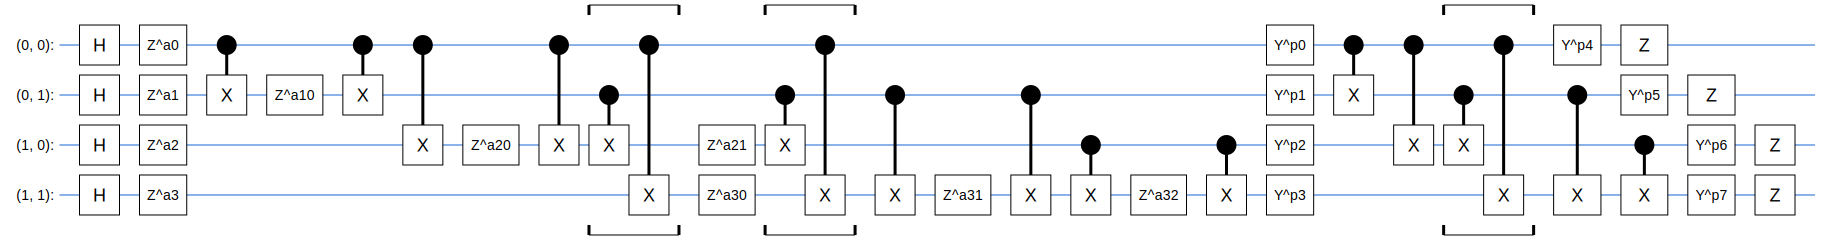

In [12]:
QConv(filter_size=2, depth=1, activation='relu').svg

## Build and train a simple model

In [10]:
log = False

width = np.shape(train_images)[1]
height = np.shape(train_images)[2]

qcnn_model = models.Sequential()


qcnn_model.add(QConv(filter_size=2, strides=(2,2), depth=1, activation='relu', 
                     name='qconv1', input_shape=(width, height, 1)))
qcnn_model.add(QConv(filter_size=2, strides=(1,1), depth=2, activation='relu', 
                     name='qconv2', input_shape=(width, height, 1)))
qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(32, activation='relu'))
qcnn_model.add(layers.Dense(10, activation='softmax'))

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if log:
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

circuit_tensor: (49,)
circuit_tensor: (36,)


In [11]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

qcnn_history = qcnn_model.fit(train_images, train_labels,
                        validation_split = 0.3, 
                        epochs=10, batch_size=64,
                        callbacks=[tensorboard_callback] if log else None,
                        )

Epoch 1/10
14/55 [======>.......................] - ETA: 5:02:31 - loss: 2.3305 - accuracy: 0.1217

## Produce output of trained circuit

In [8]:
import pickle


# save model weights
qcnn_model.save_weights('qcnn_weights_10x10_2x2_1x1_2_32.h5')
with open('qcnn_history_10x10_2x2_1x1_2_32.pkl', 'wb') as f:
    pickle.dump(qcnn_history, f)
    pickle.dump(qcnn_model, f)

2022-05-24 21:42:59.104999: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://d8be77cb-7835-4d60-9510-8f2547b129e8/assets


INFO:tensorflow:Assets written to: ram://d8be77cb-7835-4d60-9510-8f2547b129e8/assets


INFO:tensorflow:Assets written to: ram://aa33f36d-c4a2-4df9-b639-b3f6500663b5/assets


INFO:tensorflow:Assets written to: ram://aa33f36d-c4a2-4df9-b639-b3f6500663b5/assets


In [41]:
import h5py
n_filters = 1               # depth of conv layer
with h5py.File(f'qcnn_weights_10x10_2x2_2x2_{n_filters}_5.h5','r') as f:
    qcnn_weights = f["qconv1"]["qconv1"]["kenel:0"]
    n_weights = qcnn_weights.shape[1]//n_filters
    filters_param = [qcnn_weights[0, n_weights*i : n_weights*(i+1)] for i in range(n_filters) ]
    


In [42]:
for i in range(n_filters):
    print(filters_param[i])

[-0.49909627 -0.50000006  0.17618683  0.18435144  0.18223746  0.7552349 ]


In [43]:
# build the parametrized circuit
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
n_layers = 1
n_qubits = 4  
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, n_qubits))

@qml.qnode(device=dev, interface='tf')
def circuit(phi_in, phi_var):
    # Encoding of classical input values
    for j in range(n_qubits):
        qml.RX(np.pi*phi_in[j], wires=j)

    qml.CRZ(phi_var[0], [0,1])
    qml.CRX(phi_var[1], [0,1])

    qml.CRZ(phi_var[2], [2,3])
    qml.CRX(phi_var[3], [2,3])

    qml.CRZ(phi_var[4], [0,2])
    qml.CRX(phi_var[5], [0,2])


    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ((i+1))) for i in range(n_layers)]

print(qml.draw(circuit)(phi_in=[0,0,0,0], phi_var=filters_param[0]))

0: ──RX(0.00)─╭C─────────╭C─────────╭C────────╭C────────┤     
1: ──RX(0.00)─╰RZ(-0.50)─╰RX(-0.50)─│─────────│─────────┤  <Z>
2: ──RX(0.00)─╭C─────────╭C─────────╰RZ(0.18)─╰RX(0.76)─┤     
3: ──RX(0.00)─╰RZ(0.18)──╰RX(0.18)──────────────────────┤     


In [48]:
# quanvolution
def quanv(image, image_size, stride, kernel_size, phi_var):
    """Convolves the input image with many applications of the same quantum circuit."""
    conv_size = int((image_size-kernel_size)/stride + 1)
    out = np.zeros((conv_size, conv_size, kernel_size**2))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, image_size-kernel_size+1, stride):
        for k in range(0, image_size-kernel_size+1, stride):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ],
                phi_var
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_layers):
                out[j // stride, k // stride, c] = q_results[c]
    return out

In [59]:
# produce n_samples output for each filter
n_samples   = 8
img_size    = 10
stride      = 2
filter_size = 2

t_circ_out = []
for i in range(n_filters):
    # process input images
    q_trained_images = []
    for img in train_images[:n_samples]:
        q_trained_images.append(quanv(img, img_size, stride, filter_size, filters_param[i]))
    t_circ_out.append(np.array(q_trained_images))

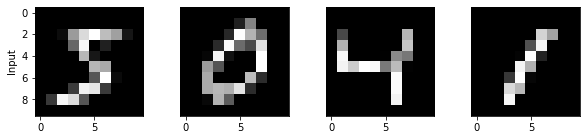

In [44]:
# print inputs
fig, axes = plt.subplots(1, n_samples, figsize=(10, 2))
for k in range(n_samples):
    axes[0].set_ylabel("Input")
    if k != 0:
        axes[k].yaxis.set_visible(False)
    axes[k].imshow(train_images[k, :, :, 0], cmap="gray")

In [12]:
import seaborn as sns

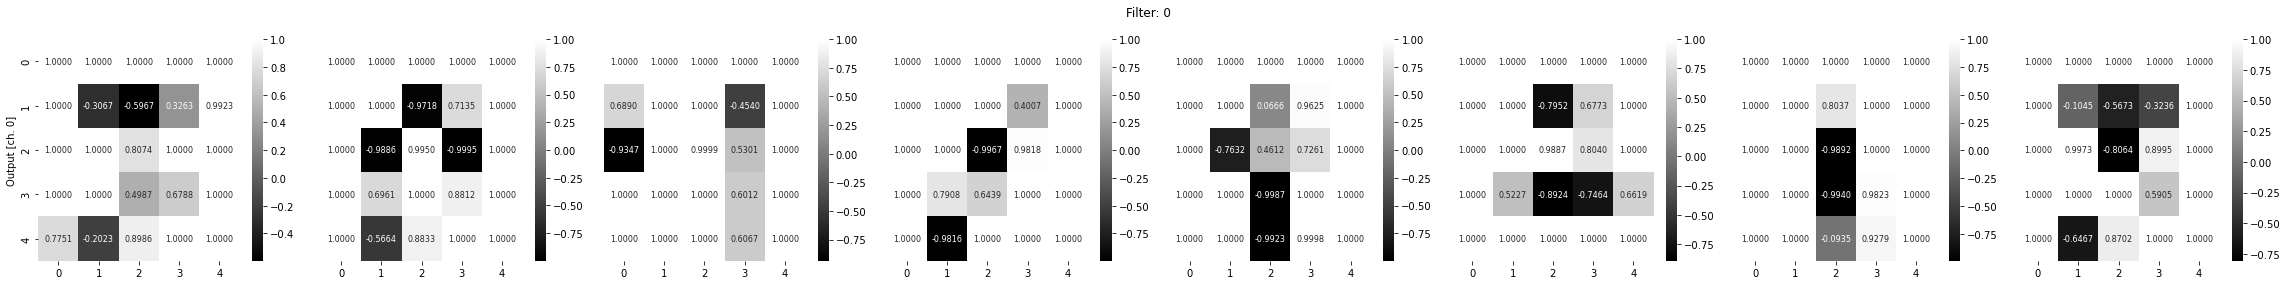

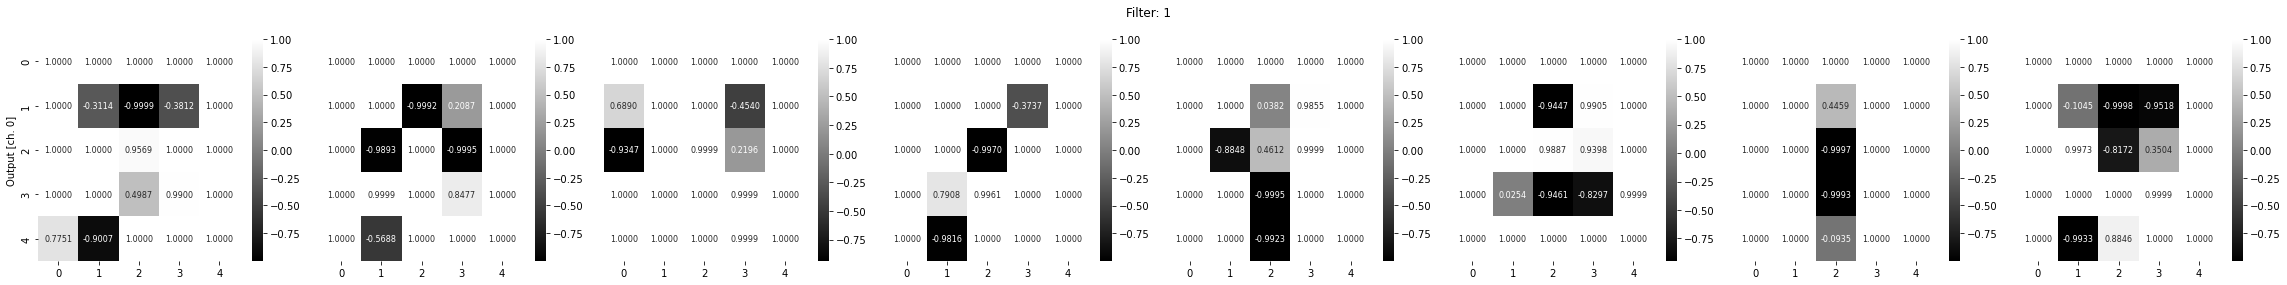

In [61]:
# print outputs
n_channels = 1
for i in range(n_filters):
    fig, axes = plt.subplots(n_channels, n_samples, figsize=(32, 4))
    for k in range(n_samples):
        for c in range(n_channels):
            ax = axes[c, :] if n_channels > 1 else axes
            ax[0].set_ylabel("Output [ch. {}]".format(c))
            if k != 0:
                ax[k].yaxis.set_visible(False)
            #ax[k].imshow(t_circ_out[i][k, :, :, c], cmap="gray")
            sns.heatmap(t_circ_out[i][k, :, :, c], cmap='gray', annot=t_circ_out[i][k, :, :, c], annot_kws={'fontsize': 8}, fmt='.4f', ax=ax[k])
    plt.suptitle(f'Filter: {i}')
    plt.tight_layout()
    plt.savefig(f'./images/t_quanv_1_out_{i}.png')

## Classical model comparison

In [177]:
def cnn_model(img_size = 28,
              channels = 1):
    cnn_model = models.Sequential([
        layers.Conv2D(filters=1, kernel_size=2, activation='relu', strides = (1,1), input_shape=(img_size, img_size, channels), data_format='channels_last'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='softmax')]
    )

    cnn_model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return cnn_model

In [178]:
cnn = cnn_model(
    img_size = 10
)
n_epochs = 15
#steps_per_epoch = 40
batch_size = 5

In [179]:
cnn_history = cnn.fit(train_images, train_labels,
                            #steps_per_epoch = steps_per_epoch,
                            #validation_data=(valid_images, valid_labels),
                            validation_split = 0.3,
                            batch_size=batch_size,
                            epochs=n_epochs, 
                            verbose=2)

Epoch 1/15
700/700 - 2s - loss: 1.4882 - accuracy: 0.5466 - val_loss: 0.8794 - val_accuracy: 0.7480 - 2s/epoch - 3ms/step
Epoch 2/15
700/700 - 2s - loss: 0.6737 - accuracy: 0.7954 - val_loss: 0.6243 - val_accuracy: 0.8140 - 2s/epoch - 3ms/step
Epoch 3/15
700/700 - 2s - loss: 0.5342 - accuracy: 0.8360 - val_loss: 0.5241 - val_accuracy: 0.8360 - 2s/epoch - 3ms/step
Epoch 4/15
700/700 - 2s - loss: 0.4740 - accuracy: 0.8594 - val_loss: 0.5023 - val_accuracy: 0.8447 - 2s/epoch - 2ms/step
Epoch 5/15
700/700 - 2s - loss: 0.4406 - accuracy: 0.8666 - val_loss: 0.4771 - val_accuracy: 0.8547 - 2s/epoch - 2ms/step
Epoch 6/15
700/700 - 2s - loss: 0.4184 - accuracy: 0.8774 - val_loss: 0.4710 - val_accuracy: 0.8527 - 2s/epoch - 2ms/step
Epoch 7/15
700/700 - 2s - loss: 0.4020 - accuracy: 0.8829 - val_loss: 0.4940 - val_accuracy: 0.8447 - 2s/epoch - 2ms/step
Epoch 8/15
700/700 - 2s - loss: 0.3870 - accuracy: 0.8877 - val_loss: 0.4617 - val_accuracy: 0.8600 - 2s/epoch - 2ms/step
Epoch 9/15
700/700 - 2s 

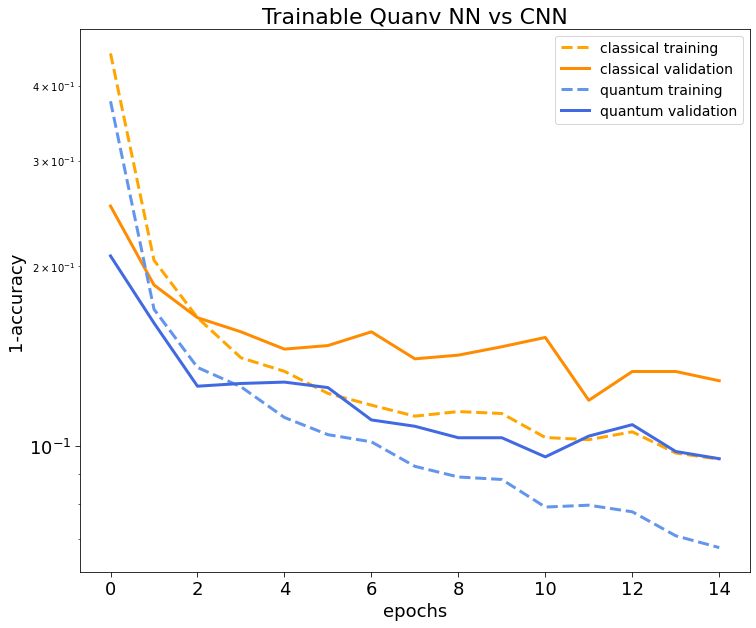

In [182]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Trainable Quanv NN vs CNN", fontsize=22)
ax.set_xlabel("epochs",     fontsize=18)
ax.set_ylabel("1-accuracy", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18, length=5)
ax.grid

colors = ["orange", "darkorange", "cornflowerblue", "royalblue"]
labels = ["classical training", "classical validation", "quantum training", "quantum validation"]
keys   = ["accuracy", "val_accuracy"]
style  = ["dashed", "solid"]*2
performances = [cnn_history.history[key] for key in keys] + [qcnn_history.history[key] for key in keys]

for i in range(4):
    ax.plot(
        np.arange(0, 15, 1), 1-np.array(performances[i]),
        lw    = 3,
        linestyle = style[i],
        label = labels[i],
        color = colors[i]
    )

#ax.set_ylim(0,1)
ax.set_yscale("log")

ax.legend(
    fontsize=14
)